In [24]:
#Research Question 2: Why do different object detection models (Faster R-CNN vs DETR) exhibit varying True Positive Rates and Attack Success Rates when processing images containing phantom objects under daylight conditions?  

In [25]:
#Import Statements
import matplotlib.pyplot as plt
import torch
import os
import zipfile
import uuid
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from tqdm import tqdm
import numpy as np

In [19]:
#Paths
main_zip_path = "dataverse_files.zip"  #Main ZIP file
intermediate_folder = "dataverse_files"  #Where main ZIP will be extracted
label_zip_path = os.path.join(intermediate_folder, "Label.zip")  #Inside extracted folder
extract_folder = "labels"  #Final destination for label files

#Step 1: Extracts 'dataverse_files.zip' if needed
if os.path.exists(main_zip_path):
    print(f"📂 Extracting {main_zip_path}...")
    os.makedirs(intermediate_folder, exist_ok=True)
    with zipfile.ZipFile(main_zip_path, 'r') as main_zip:
        main_zip.extractall(intermediate_folder)

#Step 2: Extracts 'Label.zip' inside dataverse_files
if os.path.exists(label_zip_path):
    print(f"📂 Extracting {label_zip_path}...")
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(label_zip_path, 'r') as label_zip:
        label_zip.extractall(extract_folder)

    print(f"✅ Extracted Label.zip into '{extract_folder}' folder.")
else:
    print("⚠️ Label.zip not found inside 'dataverse_files'!")

📂 Extracting dataverse_files.zip...
📂 Extracting dataverse_files/Label.zip...
✅ Extracted Label.zip into 'labels' folder.


In [20]:
#Defines paths
zip_path = "Left_images1.zip"  # Zip file to extract
extract_folder = "lefty"  # Destination folder

#Creates output directory if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

#Extracts the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"✅ Extracted Left_images1.zip into '{extract_folder}' folder without renaming images.")

✅ Extracted Left_images1.zip into 'lefty' folder without renaming images.


In [26]:
#Path to label files
label_folder = "labels/Label"  # Folder containing label files

#Checks the first 5 label files for testing purposes (Cross-check this with the actual .txt files on own for verification purposes)
for label_file in os.listdir(label_folder)[:5]:  
    print(f"📄 Checking file: {label_file}")
    with open(os.path.join(label_folder, label_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            print(f"🔍 Label Line: {line.strip()}")


📄 Checking file: 000824.txt
🔍 Label Line: Car 794 350 1807 1070 0 0 0 0 0 0 0 R
🔍 Label Line: Traffic_light 1104 443 1202 628 0 0 0 0 0 0 0 F
📄 Checking file: 003083.txt
🔍 Label Line: Person 1132 261 1294 829 0 0 0 0 0 0 0 F
🔍 Label Line: Person 1319 275 1481 832 0 0 0 0 0 0 0 F
📄 Checking file: 001045.txt
🔍 Label Line: Car 413 342 930 776 0 0 0 0 0 0 0 R
🔍 Label Line: Traffic_light 507 370 758 525 0 0 0 0 0 0 0 F
📄 Checking file: 002714.txt
🔍 Label Line: Stop_sign 0 375 135 510 0 0 0 0 0 0 0 F
🔍 Label Line: Car 1 359 492 805 0 0 0 0 0 0 0 R
📄 Checking file: 000435.txt
🔍 Label Line: Car 509 337 949 724 0 0 0 0 0 0 0 R
🔍 Label Line: Car 633 406 773 454 0 0 0 0 0 0 0 F


In [27]:
#Loops through 1st 5 label files in specified folder, reads each file line-by-line,
#extracts "authenticity" value (assumed to be the last column in each line and is either R or F).
#This helps verify whether objects in each label are real or fake.

for label_file in os.listdir(label_folder)[:5]:  
    print(f"📄 Checking file: {label_file}")
    with open(os.path.join(label_folder, label_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            authenticity = parts[-1]  #Last column
            print(f"🔍 Extracted Authenticity: {authenticity}")


📄 Checking file: 000824.txt
🔍 Extracted Authenticity: F
🔍 Extracted Authenticity: F
📄 Checking file: 003083.txt
🔍 Extracted Authenticity: F
🔍 Extracted Authenticity: F
📄 Checking file: 001045.txt
🔍 Extracted Authenticity: F
🔍 Extracted Authenticity: F
📄 Checking file: 002714.txt
🔍 Extracted Authenticity: F
🔍 Extracted Authenticity: F
📄 Checking file: 000435.txt
🔍 Extracted Authenticity: F
🔍 Extracted Authenticity: F


In [28]:
# ===========================
#Faster R-CNN (Vision-Based 2D Object Detection Model) Experiment Setup
# ===========================

#GPUs Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using {torch.cuda.device_count()} GPUs!")

#Pre-training Faster R-CNN with Default COCO Dataset
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model = torch.nn.DataParallel(model)
model.eval()

#Image preprocessing: Images resized to 1000 pixels and converted to tensors
transform = transforms.Compose([
    transforms.Resize(1000),
    transforms.ToTensor(),
])

#File Paths: Setting variables for Left_images1 (Left Camera Daytime Images Folder) and Label (.txt Label Files Folder)
image_folder = "lefty/Left_images1"
label_folder = "labels/Label"

# ===========================
#Utility: Compute IoU
# ===========================

def compute_iou(boxA, boxB):
    #Compute the (x, y) coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])#Left boundary of the intersection
    yA = max(boxA[1], boxB[1])#Top boundary of the intersection
    xB = min(boxA[2], boxB[2])#Right boundary of the intersection
    yB = min(boxA[3], boxB[3])#Bottom boundary of the intersection
    #Computes area of the intersection rectangle. max(0, ...) ensures that we don't get a negative area when boxes don't overlap
    interArea = max(0, xB - xA) * max(0, yB - yA)
    #Computes area of both the prediction and ground-truth bounding boxes
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    #Computes Intersection over Union (IoU). Add a small epsilon (1e-6) to the denominator to prevent division by zero
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

# ===========================
#Load All GT Boxes
# ===========================

gt_data = {}  # image_name.png → [(bbox, authenticity)]
for label_file in os.listdir(label_folder):
    #Processes only .txt files 
    if not label_file.endswith(".txt"):
        continue
    #Derives corresponding image filename (same base name with .png extension)
    image_name = label_file.replace(".txt", ".png")
    image_path = os.path.join(image_folder, image_name)
    
    #Skips this file if the corresponding image does not exist
    if not os.path.exists(image_path):
        continue

    boxes = []#Temporary list to hold valid (bbox, authenticity) entries for this image
    
    #Reads label file line by line
    with open(os.path.join(label_folder, label_file), "r") as f:
        for line in f:
            parts = line.strip().split()
            #Skips malformed lines that don't have at least 6 elements
            if len(parts) < 6:
                continue
            try:
                #Extracts bounding box coordinates (assumed format: class_id xmin ymin xmax ymax authenticity)
                xmin, ymin, xmax, ymax = map(float, parts[1:5])
                #Extracts and normalize the authenticity label (e.g., "R" for real or "F" for fake)
                authenticity = parts[-1].strip().upper()
                #Appends a tuple of bounding box and authenticity label to the list
                boxes.append(([xmin, ymin, xmax, ymax], authenticity))
            except ValueError:
                continue #Skips line if coordinate parsing fails

    if boxes:#Stores entries in the main dictionary only if there is at least one valid bounding box
        gt_data[image_name] = boxes

#Final output: show how many images had valid GT annotations loaded
print(f"📊 Loaded ground truth boxes for {len(gt_data)} images.")

# ===========================
#Evaluation Metrics Init
# ===========================

tp_real = 0
fn_real = 0
tp_fake = 0
fn_fake = 0

iou_threshold = 0.1
confidence_threshold = 0.3

# ===========================
#Main Detection Loop
# ===========================

#Loops through each image and associated ground truth boxes
for image_file, gt_boxes in tqdm(gt_data.items(), desc="🚀 Evaluating Images"):
    #Load and preprocess image
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)#Apply transforms and add batch dimension
    
    #Runs inference on image without computing gradients (for speed & memory efficiency)
    with torch.no_grad():
        predictions = model(image_tensor)

    #Extracts predicted bounding boxes and their confidence scores
    detected_boxes = predictions[0]['boxes'].cpu().numpy()
    detected_scores = predictions[0]['scores'].cpu().numpy()
    
    #Filters out predictions below the confidence threshold
    filtered_boxes = [
        detected_boxes[i] for i, score in enumerate(detected_scores) if score >= confidence_threshold
    ]

    matched_preds = set()#Tracks which predicted boxes have been matched already (1-to-1 match)
    
    #Matches each ground truth box with a prediction using IoU
    for gt_box, auth in gt_boxes:
        matched = False
        for i, pred_box in enumerate(filtered_boxes):
            if i in matched_preds:
                continue
            iou = compute_iou(gt_box, pred_box)#Compute IoU between GT and predicted box
            #If IoU exceeds the threshold, count as a true positive
            if iou >= iou_threshold:
                matched_preds.add(i)#Mark this prediction as used
                matched = True
                #Count as true positive based on authenticity label
                if auth == "R":
                    tp_real += 1
                elif auth == "F":
                    tp_fake += 1
                break#Stop looking once matched
        
        #If GT box did not match with any prediction, count as a false negative
        if not matched:
            if auth == "R":
                fn_real += 1
            elif auth == "F":
                fn_fake += 1

# ===========================
#Final Metric Computation
# ===========================

#Phantom detection evaluation (ASR/TPR)
ASR = fn_fake / 3409

#Real object TPR (optional bonus stat)
TPR_real = tp_real / (tp_real + fn_real + 1e-6)

print(f"\n✅ TPR (Real Objects): {TPR_real:.2%}")
print(f"🚨 ASR (Attack Success Rate): {ASR:.2%}")

🔥 Using 2 GPUs!
📊 Loaded ground truth boxes for 1639 images.


🚀 Evaluating Images: 100%|██████████| 1639/1639 [03:13<00:00,  8.47it/s]


✅ TPR (Real Objects): 99.88%
🚨 ASR (Attack Success Rate): 22.00%


In [29]:
# ===========================
#DETR (Vision-Based 2D Object Detection Model) Experiment Setup
# ===========================

#GPUs Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using {torch.cuda.device_count()} GPUs!")

#Loads DETR model (pre-trained on COCO Dataset)
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.to(device)
model = torch.nn.DataParallel(model)
model.eval()

#Image preprocessing: Images resized to 1000 pixels and converted to tensors
transform = transforms.Compose([
    transforms.Resize(1000),
    transforms.ToTensor(),
])

#File paths (Setting variables for Left_images1 (Left Camera Daytime Images Folder) and Label (.txt Label Files Folder)
image_folder = "lefty/Left_images1"
label_folder = "labels/Label"

# ===========================
#Utility: IoU Calculation
# ===========================

def compute_iou(boxA, boxB):
    #get coordinates of the intersection example
    xA = max(boxA[0], boxB[0])#Left-most x of overlap
    yA = max(boxA[1], boxB[1])#Top-most y of overlap
    xB = min(boxA[2], boxB[2])#Right-most x of overlap
    yB = min(boxA[3], boxB[3])#Bottom-most y of overlap
    #Computes area of intersection (clipped at 0 to avoid negatives)
    interArea = max(0, xB - xA) * max(0, yB - yA)
    #Computes area of both bounding boxes
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    #Computes Intersection over Union (IoU)
    #Adds 1e-6 to denominator to avoid division by zero in edge cases
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

# ===========================
#Load GT Labels
# ===========================

gt_data = {}#Dictionary mapping: image_name.png → list of tuples (bounding_box, authenticity_label)

for label_file in os.listdir(label_folder):
    #Only processes .txt files that contain annotations
    if not label_file.endswith(".txt"):
        continue
    
    #Gets corresponding image file name (assuming same base name with .png extension)
    image_name = label_file.replace(".txt", ".png")
    try:
        #Ensures filename starts with a valid number (used to filter image indices)
        image_number = int(image_name.split(".")[0])
        #Skips images outside the expected range (0–1639)
        if image_number < 0 or image_number > 1639:
            continue
    except ValueError: #Skip filenames that don't start with a numeric ID
        continue
    
    #Full path to corresponding image
    image_path = os.path.join(image_folder, image_name)
    #Skip if corresponding image does not exist in the folder
    if not os.path.exists(image_path):
        continue

    entries = []#Stores all valid (bbox, authenticity) entries for image
    
    #Open and read each line in annotation file
    with open(os.path.join(label_folder, label_file), "r") as f:
        for line in f:
            parts = line.strip().split()
            
            #Skip malformed lines (expecting at least 6 parts: class_id, bbox coords, and authenticity)
            if len(parts) < 6:
                continue
            try:
                #Extracts bounding box coordinates (assumed format: class_id xmin ymin xmax ymax auth)
                xmin, ymin, xmax, ymax = map(float, parts[1:5])
                #Standardizes authenticity label (e.g., REAL or FAKE)
                authenticity = parts[-1].strip().upper()
                #Appends to image's entries
                entries.append(([xmin, ymin, xmax, ymax], authenticity))
            except ValueError:#Skip if any coordinate value isn't a valid float
                continue

    if entries:#Stores only if image has valid entries
        gt_data[image_name] = entries

print(f"📊 Loaded GT annotations for {len(gt_data)} images") #1639

# ===========================
#Metric Initialization
# ===========================

tp_real = 0
fn_real = 0
tp_fake = 0
fn_fake = 0

iou_threshold = 0.1
confidence_threshold = 0.3

# ===========================
#Evaluation Loop
# ===========================

#Loops through each image and its associated GT boxes
for image_file, gt_boxes in tqdm(gt_data.items(), desc="🚀 Processing Images"):
    image_path = os.path.join(image_folder, image_file)
    
    #Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    #Run image through model (no gradient calculation needed)
    with torch.no_grad():
        outputs = model(image_tensor)
    
    #Gets predicted class scores and bounding boxes
    pred_logits = outputs['pred_logits'][0].cpu()
    pred_boxes = outputs['pred_boxes'][0].cpu().numpy()  # normalized (cx, cy, w, h)
    
    #Computes class probabilities using softmax
    probs = torch.softmax(pred_logits, dim=-1)
    scores, labels = probs.max(-1)
    
    #Filter out predictions with low confidence
    keep = scores > confidence_threshold

    pred_boxes = pred_boxes[keep.numpy()]
    width, height = image.size #Needed to scale normalized boxes back to pixel coordinates

    #Convert to (xmin, ymin, xmax, ymax)
    detected_boxes = []
    for box in pred_boxes:
        cx, cy, w, h = box
        xmin = int((cx - w / 2) * width)
        ymin = int((cy - h / 2) * height)
        xmax = int((cx + w / 2) * width)
        ymax = int((cy + h / 2) * height)
        detected_boxes.append([xmin, ymin, xmax, ymax])

    matched_preds = set()#keeps track of which predictions have been matched to GT boxes
    
    #Matches GT boxes with predicted boxes using IoU
    for gt_box, auth in gt_boxes:
        matched = False
        for i, pred_box in enumerate(detected_boxes):
            if i in matched_preds:
                continue #skips already matched predictions
            iou = compute_iou(gt_box, pred_box)
            if iou >= iou_threshold:
                matched_preds.add(i)
                matched = True
                
                #TP (correct detection of a real or fake object)
                if auth == "R":
                    tp_real += 1
                elif auth == "F":
                    tp_fake += 1
                break
        
        #If no matching prediction was found for this GT box, it's a False Negative
        if not matched:
            if auth == "R":
                fn_real += 1
            elif auth == "F":
                fn_fake += 1

# ===========================
#Final Metrics
# ===========================

TPR_real = tp_real / (tp_real + fn_real + 1e-6)  #Real TPR
ASR = fn_fake / 3409                    #ASR (based on fixed 3409)

# ===========================
#Print Results
# ===========================



print(f"\n✅ TPR (Real Objects): {TPR_real:.2%}")
print(f"🚨 ASR (Attack Success Rate): {ASR:.2%}")

🔥 Using 2 GPUs!


Using cache found in /home/jovyan/.cache/torch/hub/facebookresearch_detr_main


📊 Loaded GT annotations for 1639 images


🚀 Processing Images: 100%|██████████| 1639/1639 [03:48<00:00,  7.17it/s]


✅ TPR (Real Objects): 100.00%
🚨 ASR (Attack Success Rate): 4.87%


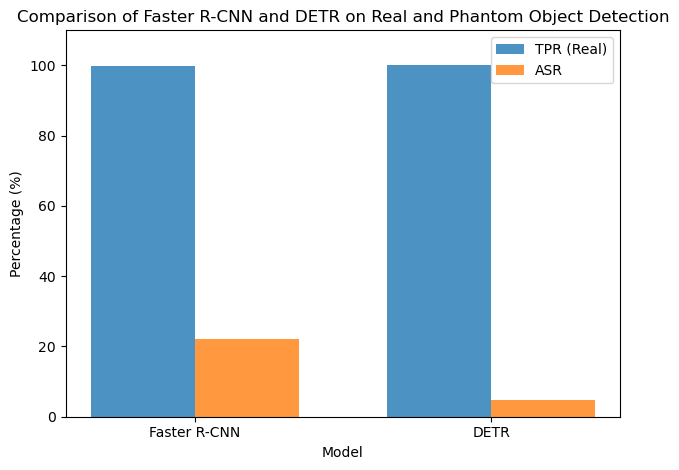

In [18]:
#Faster R-CNN vs DETR ODM Comparative Analysis Results Bar Chart

models = ['Faster R-CNN', 'DETR']
tpr = [99.88, 100.00]  #True Positive Rate (on Real Objects)
asr = [22.00, 4.87]    #Attack Success Rate

#Creates a bar chart
fig, ax = plt.subplots()

bar_width = 0.35
index = range(len(models))

#Plotting
bar1 = plt.bar(index, tpr, bar_width, label='TPR (Real)', alpha=0.8)
bar2 = plt.bar([i + bar_width for i in index], asr, bar_width, label='ASR', alpha=0.8)

plt.xlabel('Model')
plt.ylabel('Percentage (%)')
plt.title('Comparison of Faster R-CNN and DETR on Real and Phantom Object Detection')
plt.xticks([i + bar_width / 2 for i in index], models)
plt.ylim(0, 110)
plt.legend()

plt.tight_layout()
plt.show()